# DMP Final Project Notebook - Data Cleaning & EDA

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# Import preprocessing modules
from sklearn.impute import SimpleImputer
from sksurv.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

In [3]:
# modules for sentiment analysis
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
import stanza

In [6]:
# modules for word cloud
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS


In [4]:
stanza.download('en')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

2021-02-24 11:24:03 INFO: Downloading default packages for language: en (English)...
2021-02-24 11:24:24 INFO: Finished downloading models and saved to C:\Users\willm\stanza_resources.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\willm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\willm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\willm\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 1. Import & Clean Data

In [5]:
wine_150K = pd.read_csv('winemag-data_first150k.csv')
wine_130K = pd.read_csv('winemag-data-130k-v2.csv')

In [6]:
wine_150K.shape

(150930, 11)

In [7]:
wine_130K.shape

(129971, 14)

In [8]:
# 130K wine file has additional columns ('taster_name','taster_twitter_handle', 'title')
print(wine_150K.columns)
print(wine_130K.columns)

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'variety', 'winery'],
      dtype='object')
Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'taster_name',
       'taster_twitter_handle', 'title', 'variety', 'winery'],
      dtype='object')


In [9]:
wine_150K.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [10]:
wine_130K.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
total_df = wine_150K.append(wine_130K, sort=False).drop('Unnamed: 0', axis=1).reset_index(drop=True)
print(total_df.shape)
total_df.head()

(280901, 13)


,country,description,designation,points,price,province,region_1,region_2,variety,winery,taster_name,taster_twitter_handle,title
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,NaN,NaN,NaN
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,NaN,NaN,NaN
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,NaN,NaN,NaN
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,NaN,NaN,NaN
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,NaN,NaN,NaN


In [7]:
# drop irrelevant columns (taster name/handle, country, region1/2, title)
total_df= total_df.drop(columns=['country','region_1','region_2','taster_name','taster_twitter_handle','title'])
total_df.head()

,description,designation,points,price,province,variety,winery
0,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Cabernet Sauvignon,Heitz
1,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Tinta de Toro,Bodega Carmen Rodríguez
2,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Sauvignon Blanc,Macauley
3,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Pinot Noir,Ponzi
4,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Provence red blend,Domaine de la Bégude


#### Remove duplicates

In [8]:
wine_150K[wine_150K['description'].duplicated()].sort_values(by=['description']).head(6)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
147725,147725,Chile,$11. Opens with a highly perfumed bouquet of l...,Estate Reserve,84,11.0,Maipo Valley,NaN,NaN,Chardonnay,La Playa
74993,74993,US,). Very good wine from a winery increasingly k...,Rockpile Ridge Vineyard,92,47.0,California,Rockpile,Sonoma,Cabernet Sauvignon,Mauritson
53110,53110,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
84730,84730,Austria,". Christoph Neumeister's top wine, this is a c...",Moarfeitl,93,48.0,Südoststeiermark,NaN,NaN,Sauvignon Blanc,Neumeister
107351,107351,France,. From a small south-facing parcel next to the...,Trie Spéciale,91,38.0,Loire Valley,Savennières,NaN,Chenin Blanc,Domaine des Baumard
102414,102414,Germany,. Lemon zest and exotic spices enliven the nos...,Bernkasteler Badstube Kabinett,86,22.0,Mosel,NaN,NaN,Riesling,Dr. Pauly Bergweiler


In [12]:
total_df.drop_duplicates(subset ="description", 
                     keep = 'first', inplace = True)
total_df.shape

(169430, 7)

In [92]:
total_df.nunique()

description    169430
designation     47223
points             21
price             415
province          490
variety           756
winery          19180
dtype: int64

#### Drop null records

In [93]:
total_df.isnull().sum(axis=0)

description        0
designation    50067
points             0
price          12821
province          60
variety            1
winery             0
dtype: int64

In [13]:
# drop records with null province, price, variety
total_df.drop(total_df[total_df.iloc[:,3].isnull()].index, inplace = True)
total_df.drop(total_df[total_df.iloc[:,4].isnull()].index, inplace = True)
total_df.drop(total_df[total_df.iloc[:,5].isnull()].index, inplace = True)
total_df.isnull().sum(axis=0)

description        0
designation    46518
points             0
price              0
province           0
variety            0
winery             0
dtype: int64

#### Drop outliers with price > $100

In [14]:
total_df.drop(total_df[total_df['price'] > 100].index, inplace = True)

In [15]:
total_df.shape

(152261, 7)

In [102]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152261 entries, 2 to 280900
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  152261 non-null  object 
 1   designation  106521 non-null  object 
 2   points       152261 non-null  int64  
 3   price        152261 non-null  float64
 4   province     152261 non-null  object 
 5   variety      152261 non-null  object 
 6   winery       152261 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 9.3+ MB


In [103]:
total_df.to_csv('clean_wine_dataset.csv',index=False)

### Load clean data

In [11]:
total_df = pd.read_csv('clean_wine_dataset.csv')
total_df.shape

(152261, 7)

In [135]:
total_df.sample(10)

,description,designation,points,price,province,variety,winery,sentiment
129145,"The aromas bring notes of herb, sweet tobacco and ash. The plum flavors are tart and full in feel, with the tannins giving a (quite) chalky squeeze.",NaN,87,16.0,Idaho,Cabernet Sauvignon,Sawtooth,NaN
94143,"Full-bodied, rich and unctuous, this is an exotic, flamboyant white Châteauneuf-du-Pape for drinking over the next year. Grilled pineapple is drizzled with caramel and cinnamon, wrapping up long and lush.",Vieilles Vignes,94,66.0,Rhône Valley,Rhône-style White Blend,Tardieu-Laurent,1.0
45550,"You might mistake this for a young coastal Pinot. It's crisp, light-bodied and silky, with cherry, cola, herb tea and spicy, smoky flavors. If only the wine were dry.",Castelleto,84,22.0,California,Sangiovese,Mount Palomar,NaN
147274,"Produced in one of the estates belonging to the Lapalu family, this wine is soft, rounded and ready to drink now. Gentle tannins give shape and structure to the black currant-fruits that finish on a fresh, crisp note.",NaN,86,19.0,Bordeaux,Bordeaux-style Red Blend,Château Lacombe Noaillac,NaN
17956,"The bouquet of cassis, blackberry and controlled oak is welcoming, while the palate shows a spot of piercing acidity along with snappy black cherry, cassis and light olive flavors. This is a quintessential Chilean Cab with a hint of herbal charac...",Los Vascos Reserve,89,20.0,Colchagua Valley,Cabernet Sauvignon,Domaines Barons de Rothschild (Lafite),NaN
9108,"As with previous vintages, this rare wine spent 38 months in barrel. Smooth and supple, it's a lush expression of purple and black fruits, generously endowed with darker flavors of smoke, tar, soy and licorice. There is a compelling, yet subtle, ...",The Hustler,96,100.0,Washington,Syrah,K Vintners,1.0
124962,"Opaque purple in color, this extracted, grapy Malbec smells of blackberry, iodine and wood shavings. The palate is lush and fat, with more than enough tannic scrub. Hard, blocky black-fruit flavors give way to an oaky finish with spice notes.",Colección,88,19.0,Mendoza Province,Malbec,Finca Perdriel,NaN
45149,"A very delicious wine, rich in fruits and spices, and easy to drink for its softness. Shows cherry, mocha, licorice, black pepper and sweet, smoky oak flavors, wrapped into smooth tannins. Ready now.",NaN,88,22.0,California,Tempranillo,Albeno Munari,NaN
1158,"A blend of 50% Cabernet Sauvignon, 30% Merlot, 15% Cabernet Franc and 5% Petit Verdot, this conveys aromas of vanilla, oak, red currant and cedar. The hearty palate displays mature plum, dried cherry, espresso and bell pepper alongside drying tan...",Sorugo,87,40.0,Tuscany,Red Blend,Aia Vecchia,NaN
103835,"Muddled stone fruit aromas meld with overripe floral tones on the nose. There's a pop of pineapple and mango fruits on the front, with tangerine leading to a short finish. This is a straightforward but enjoyable fruit-bomb.",NaN,86,20.0,Virginia,Viognier,Horton,NaN


## 2. EDA

In [23]:
total_df.describe()

,points,price,Year
count,169369.000000,156552.000000,68930.000000
mean,88.243102,34.645824,1994.544001
std,3.145067,39.385259,189.770589
min,80.000000,4.000000,1.000000
25%,86.000000,16.000000,2010.000000
50%,88.000000,25.000000,2012.000000
75%,90.000000,40.000000,2014.000000
max,100.000000,3300.000000,7200.000000


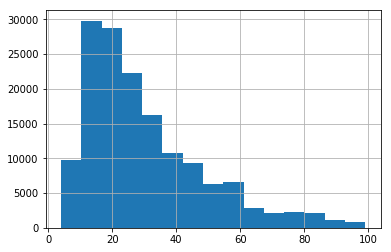

In [24]:
total_df[total_df['price'] < 100]['price'].hist(bins=15)

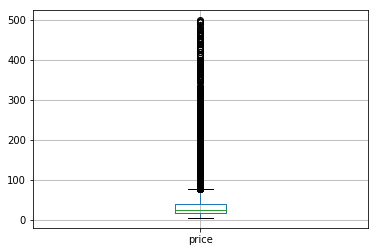

In [25]:
total_df[total_df['price'] < 500][['price']].boxplot()

In [26]:
## remove outliers - remove >$100
print("Over 100: ", sum(total_df['price'] > 100))
print("Over 500: ", sum(total_df['price'] > 500))

Over 100:  4291
Over 500:  104


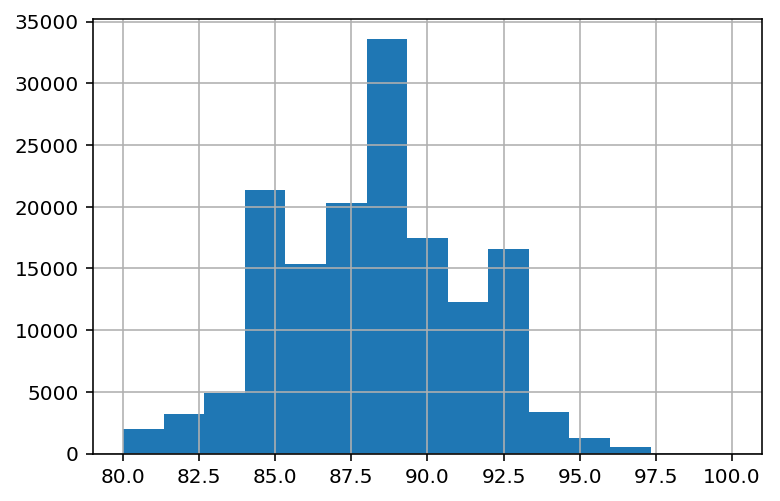

In [136]:
total_df['points'].hist(bins=15)

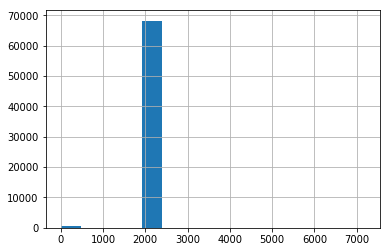

In [27]:
total_df[total_df['Year'].notnull()]['Year'].hist(bins=15)

In [ ]:
total_df[total_df['Year'] < 1600]

In [75]:
total_df.corr()

,points,price,Year,sentiment
points,1.000000,0.430993,0.016646,0.906346
price,0.430993,1.000000,0.003187,0.345520
Year,0.016646,0.003187,1.000000,0.010935
sentiment,0.906346,0.345520,0.010935,1.000000


### word analysis

In [14]:
#Frequency of words in description column
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
import re
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\willm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\willm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
top_N = 100

df_lower = total_df['description'].str.lower().str.cat(sep=' ')
df = re.sub('[^A-Za-z]+', ' ', df_lower)

#remove the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens = word_tokenize(df)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

In [22]:
# Remove characters which have length less than 2  
cleaned_data_descr = [word for word in filtered_sentence if len(word) > 2]      

In [23]:
# Calculate distribution
word_dist = nltk.FreqDist(cleaned_data_descr)
rslt = pd.DataFrame(word_dist.most_common(top_N), columns=['Word', 'Frequency'])

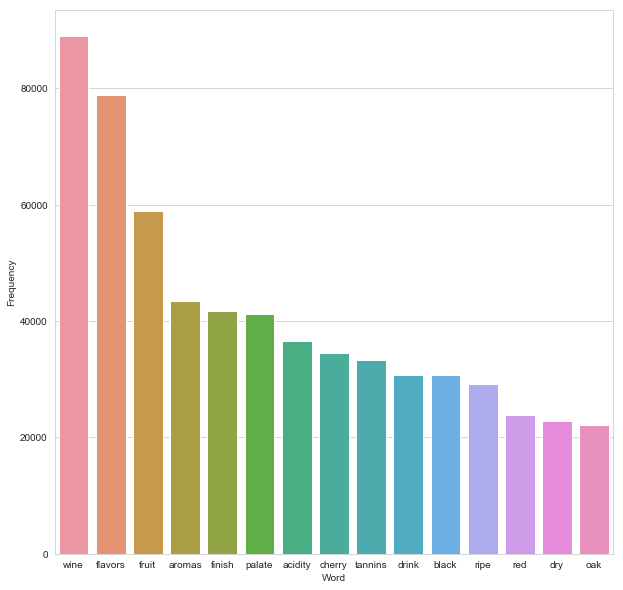

In [24]:
# plot top words
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(15))

In [34]:
def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = 280
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)

    return "hsl({}, {}%, {}%)".format(h, s, l)

In [35]:
def wc(data,bgcolor,title):
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50,color_func=random_color_func)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

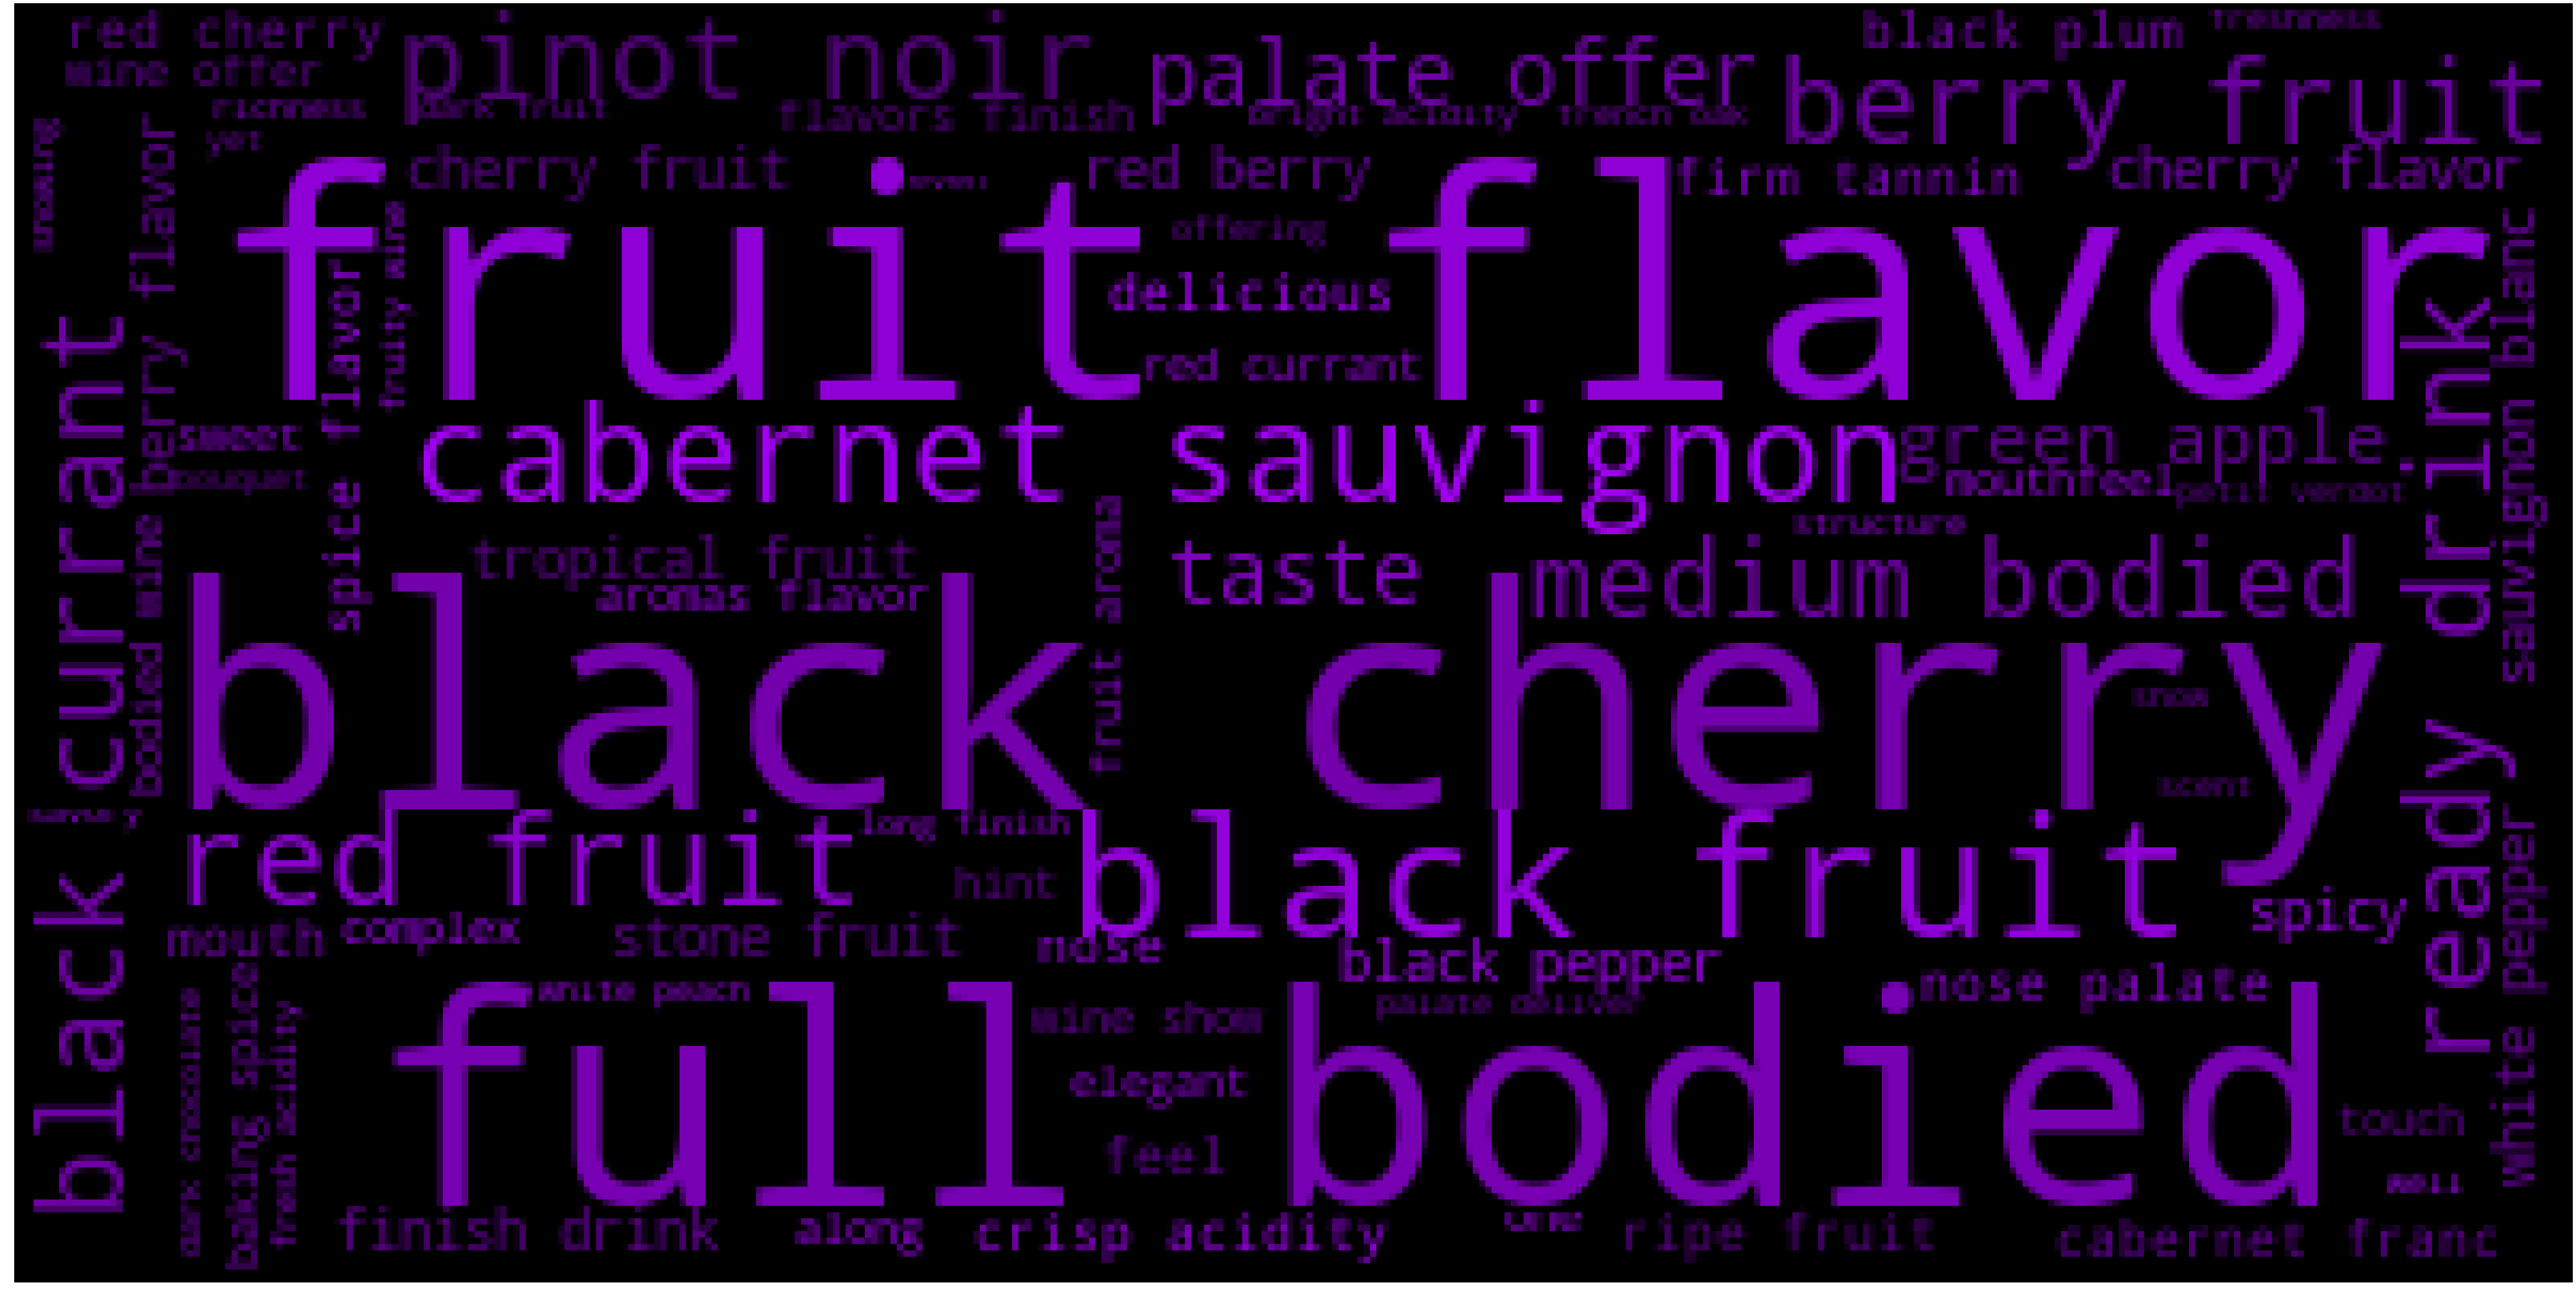

In [36]:
wc(cleaned_data_descr,'black','Common Words' )

### word analysis by sentiment

In [37]:
def to_sentiment(points):
  points = int(points)
  if points <= 83:
    return 0
  elif points >= 90:
    return 2
  else:
    return 1
total_df['sentiment'] = total_df.points.apply(to_sentiment)
class_names = ['negative', 'neutral', 'positive']

In [42]:
total_df[total_df['sentiment'] == 0]

,description,designation,points,price,province,variety,winery,sentiment
1647,"Flat and fruitless up front, this smells a bit...",NaN,83,15.0,Mendoza Province,Sauvignon Blanc,Viejo Isaias,0
1648,"Sour fruit, funky root beer, dried salami and ...",Kick Ass,83,25.0,California,Red Blend,Galante,0
1649,"This soft, robustly ripe wine shows a raisin-l...",Fog,83,34.0,California,Zinfandel,Mazzocco,0
1650,"This is a thin, unfussy wine that imparts bell...",NaN,83,65.0,California,Cabernet Sauvignon,Jeff Gordon,0
1651,"High in ripeness and intensity, this vineyard ...",Two Pear Vineyard,83,38.0,California,Zinfandel,DeLorimier,0
...,...,...,...,...,...,...,...,...
151098,"This wine, unlike the regular Porta bottling, ...",Reserve,83,13.0,Cachapoal Valley,Chardonnay,Porta,0
151099,The better side of the nose takes time to reve...,NaN,83,7.0,Mendoza Province,Chardonnay,Santa Julia,0
151100,"A decent introduction to Aussie Chardonnay, th...",Rawson's Retreat,83,11.0,Australia Other,Chardonnay,Penfolds,0
151101,Given this Chandon-owned winery's success with...,Alto,83,8.0,Mendoza Province,Chardonnay,Terrazas de Los Andes,0


In [65]:
def wc_sent(data,bgcolor,title):
    plt.figure(figsize = (50,50))
    wc = WordCloud(background_color = bgcolor, max_words = 50,  max_font_size = 50,color_func=random_color_func)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

##### Negative Sentiment

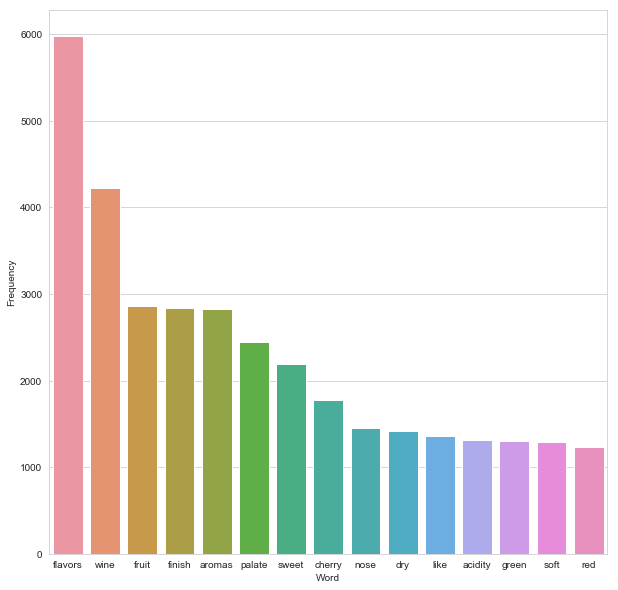

In [43]:
df_lower_neg = total_df[total_df['sentiment'] == 0]['description'].str.lower().str.cat(sep=' ')
df_neg = re.sub('[^A-Za-z]+', ' ', df_lower_neg)

#remove the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens_neg = word_tokenize(df_neg)
filtered_sentence_neg = [w for w in word_tokens_neg if not w in stop_words]
filtered_sentence_neg = []
for w in word_tokens_neg:
    if w not in stop_words:
        filtered_sentence_neg.append(w)
# Remove characters which have length less than 2  
cleaned_data_descr_neg = [word for word in filtered_sentence_neg if len(word) > 2]   
# Calculate distribution
word_dist_neg = nltk.FreqDist(cleaned_data_descr_neg)
rslt_neg = pd.DataFrame(word_dist_neg.most_common(top_N), columns=['Word', 'Frequency'])
# plot top words
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt_neg.head(15))

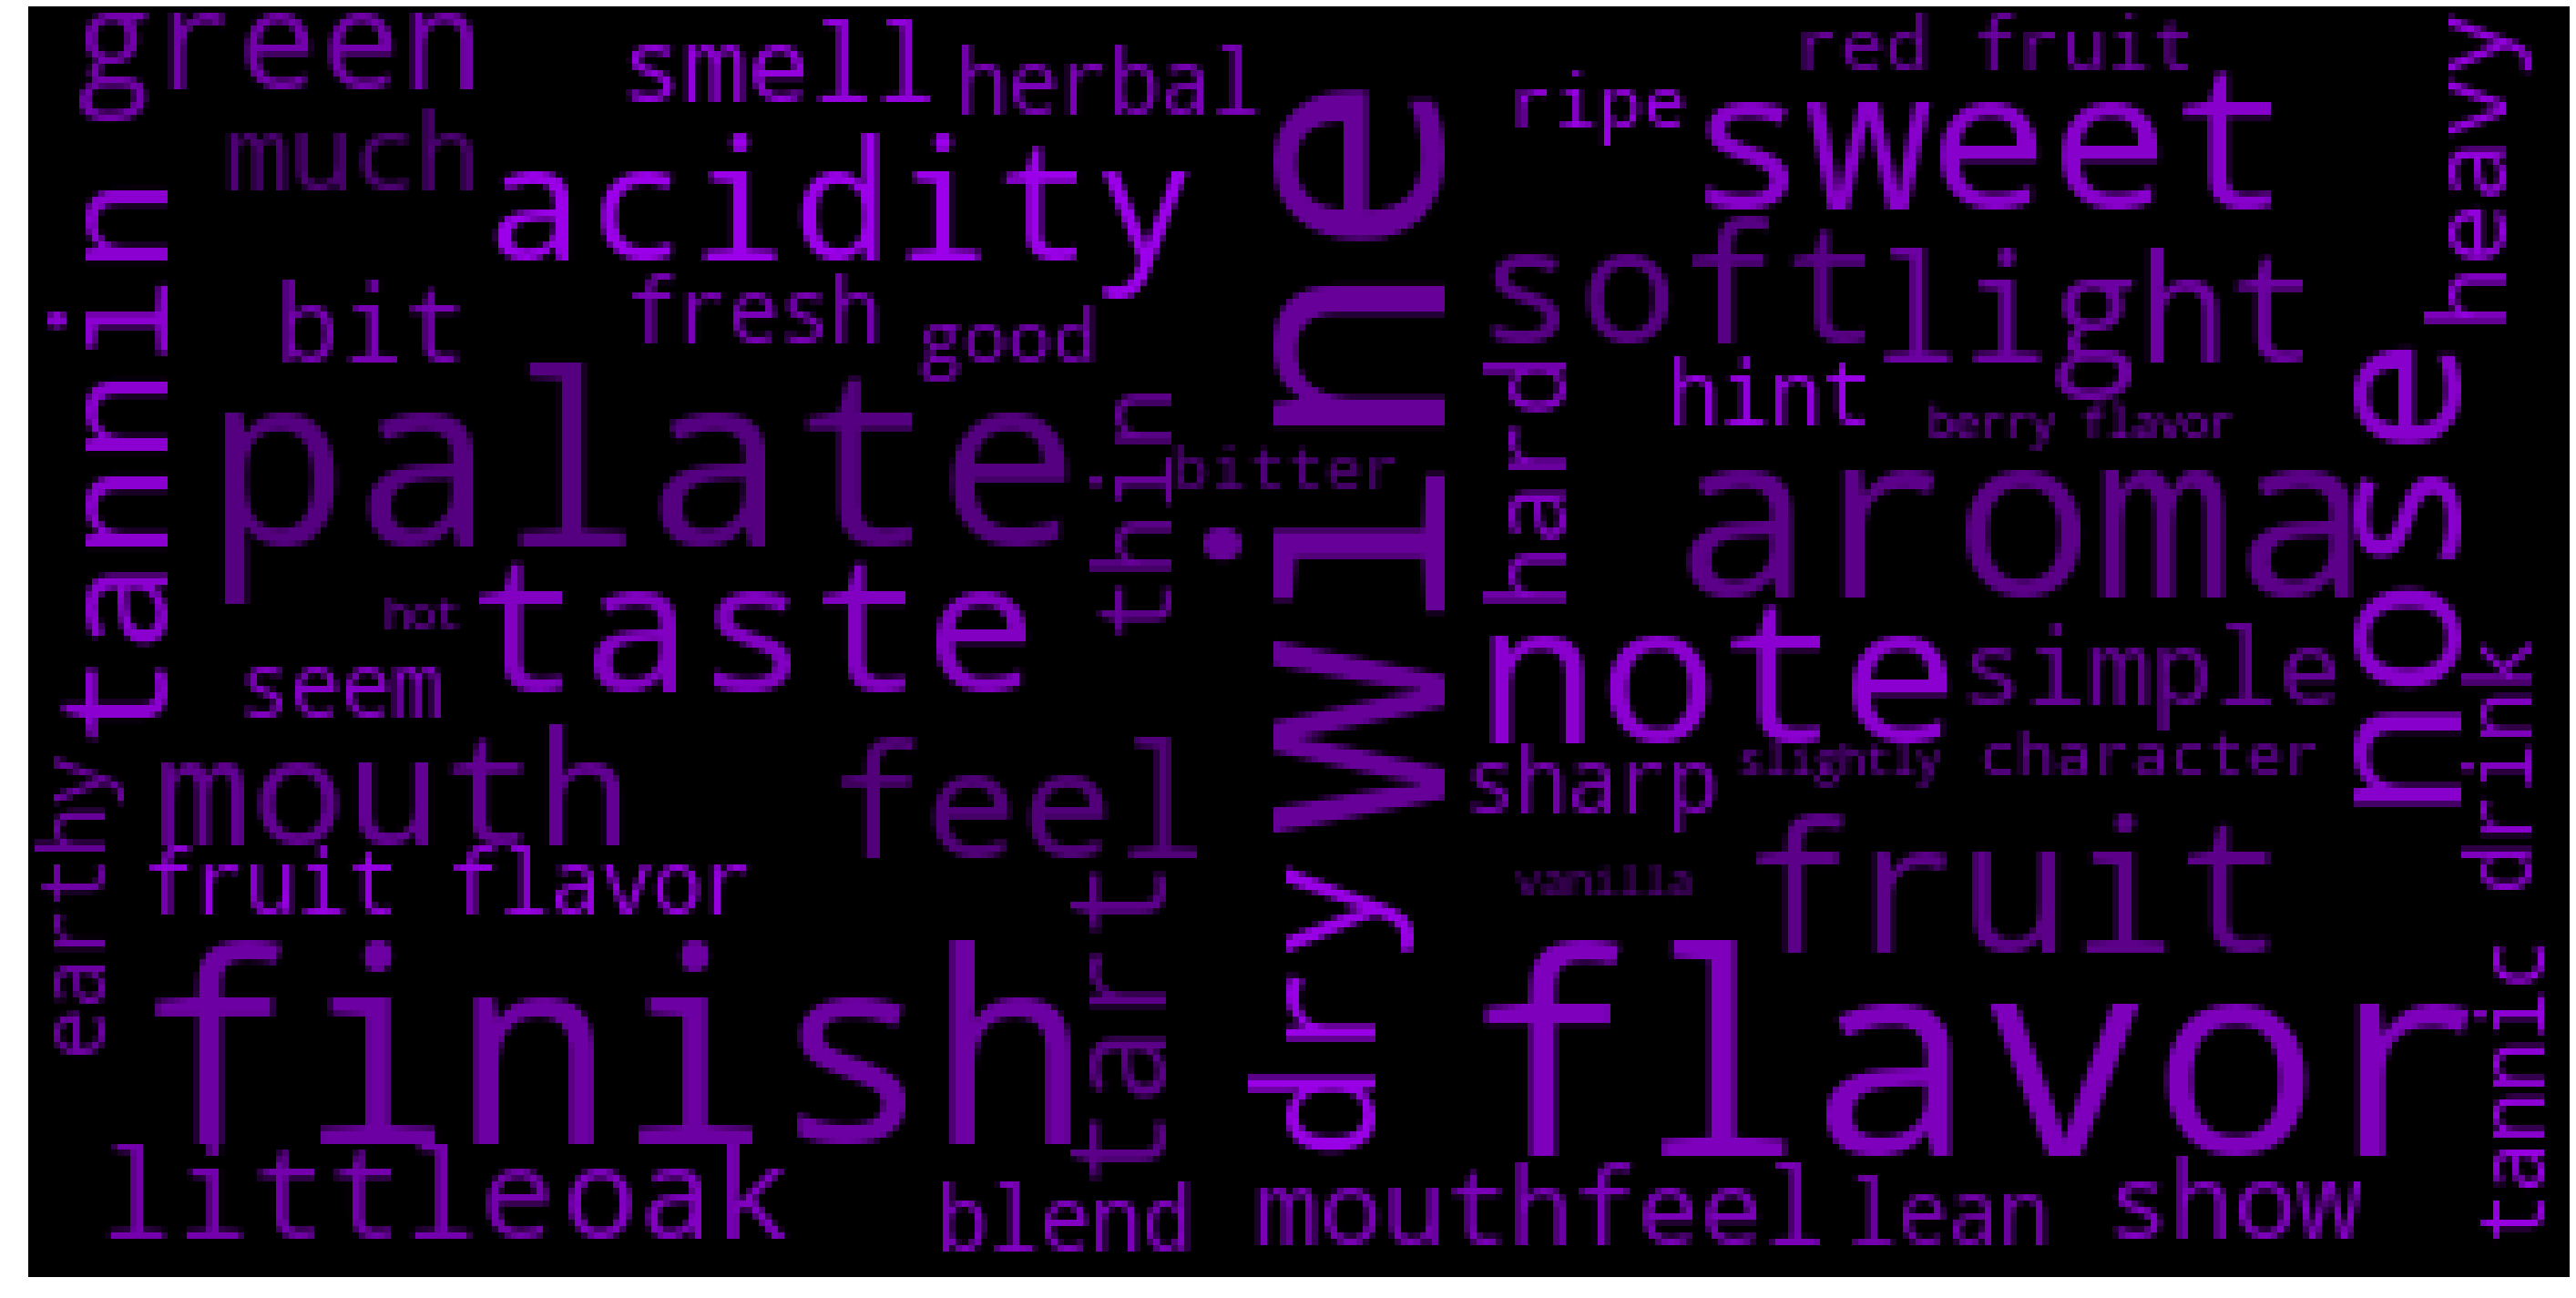

In [66]:
wc_sent(cleaned_data_descr_neg,'black','Common Words' )

##### Neutral Sentiment

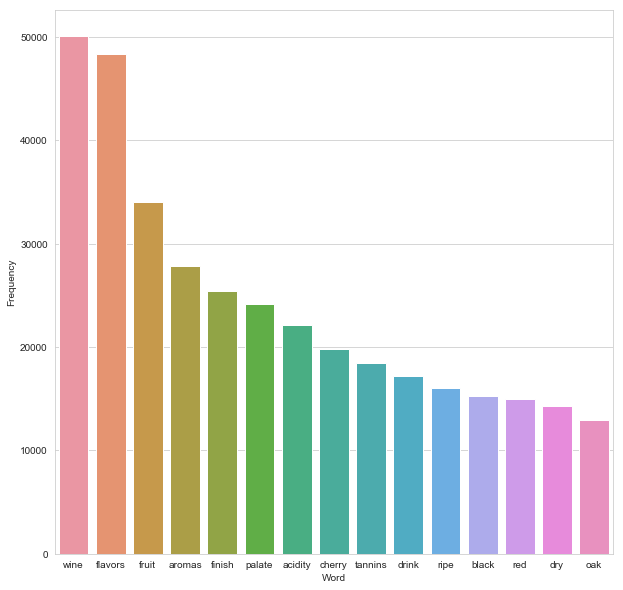

In [45]:
df_lower_neu = total_df[total_df['sentiment'] == 1]['description'].str.lower().str.cat(sep=' ')
df_neu = re.sub('[^A-Za-z]+', ' ', df_lower_neu)

#remove the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens_neu = word_tokenize(df_neu)
filtered_sentence_neu = [w for w in word_tokens_neu if not w in stop_words]
filtered_sentence_neu = []
for w in word_tokens_neu:
    if w not in stop_words:
        filtered_sentence_neu.append(w)
# Remove characters which have length less than 2  
cleaned_data_descr_neu = [word for word in filtered_sentence_neu if len(word) > 2]   
# Calculate distribution
word_dist_neu = nltk.FreqDist(cleaned_data_descr_neu)
rslt_neu = pd.DataFrame(word_dist_neu.most_common(top_N), columns=['Word', 'Frequency'])
# plot top words
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt_neu.head(15))

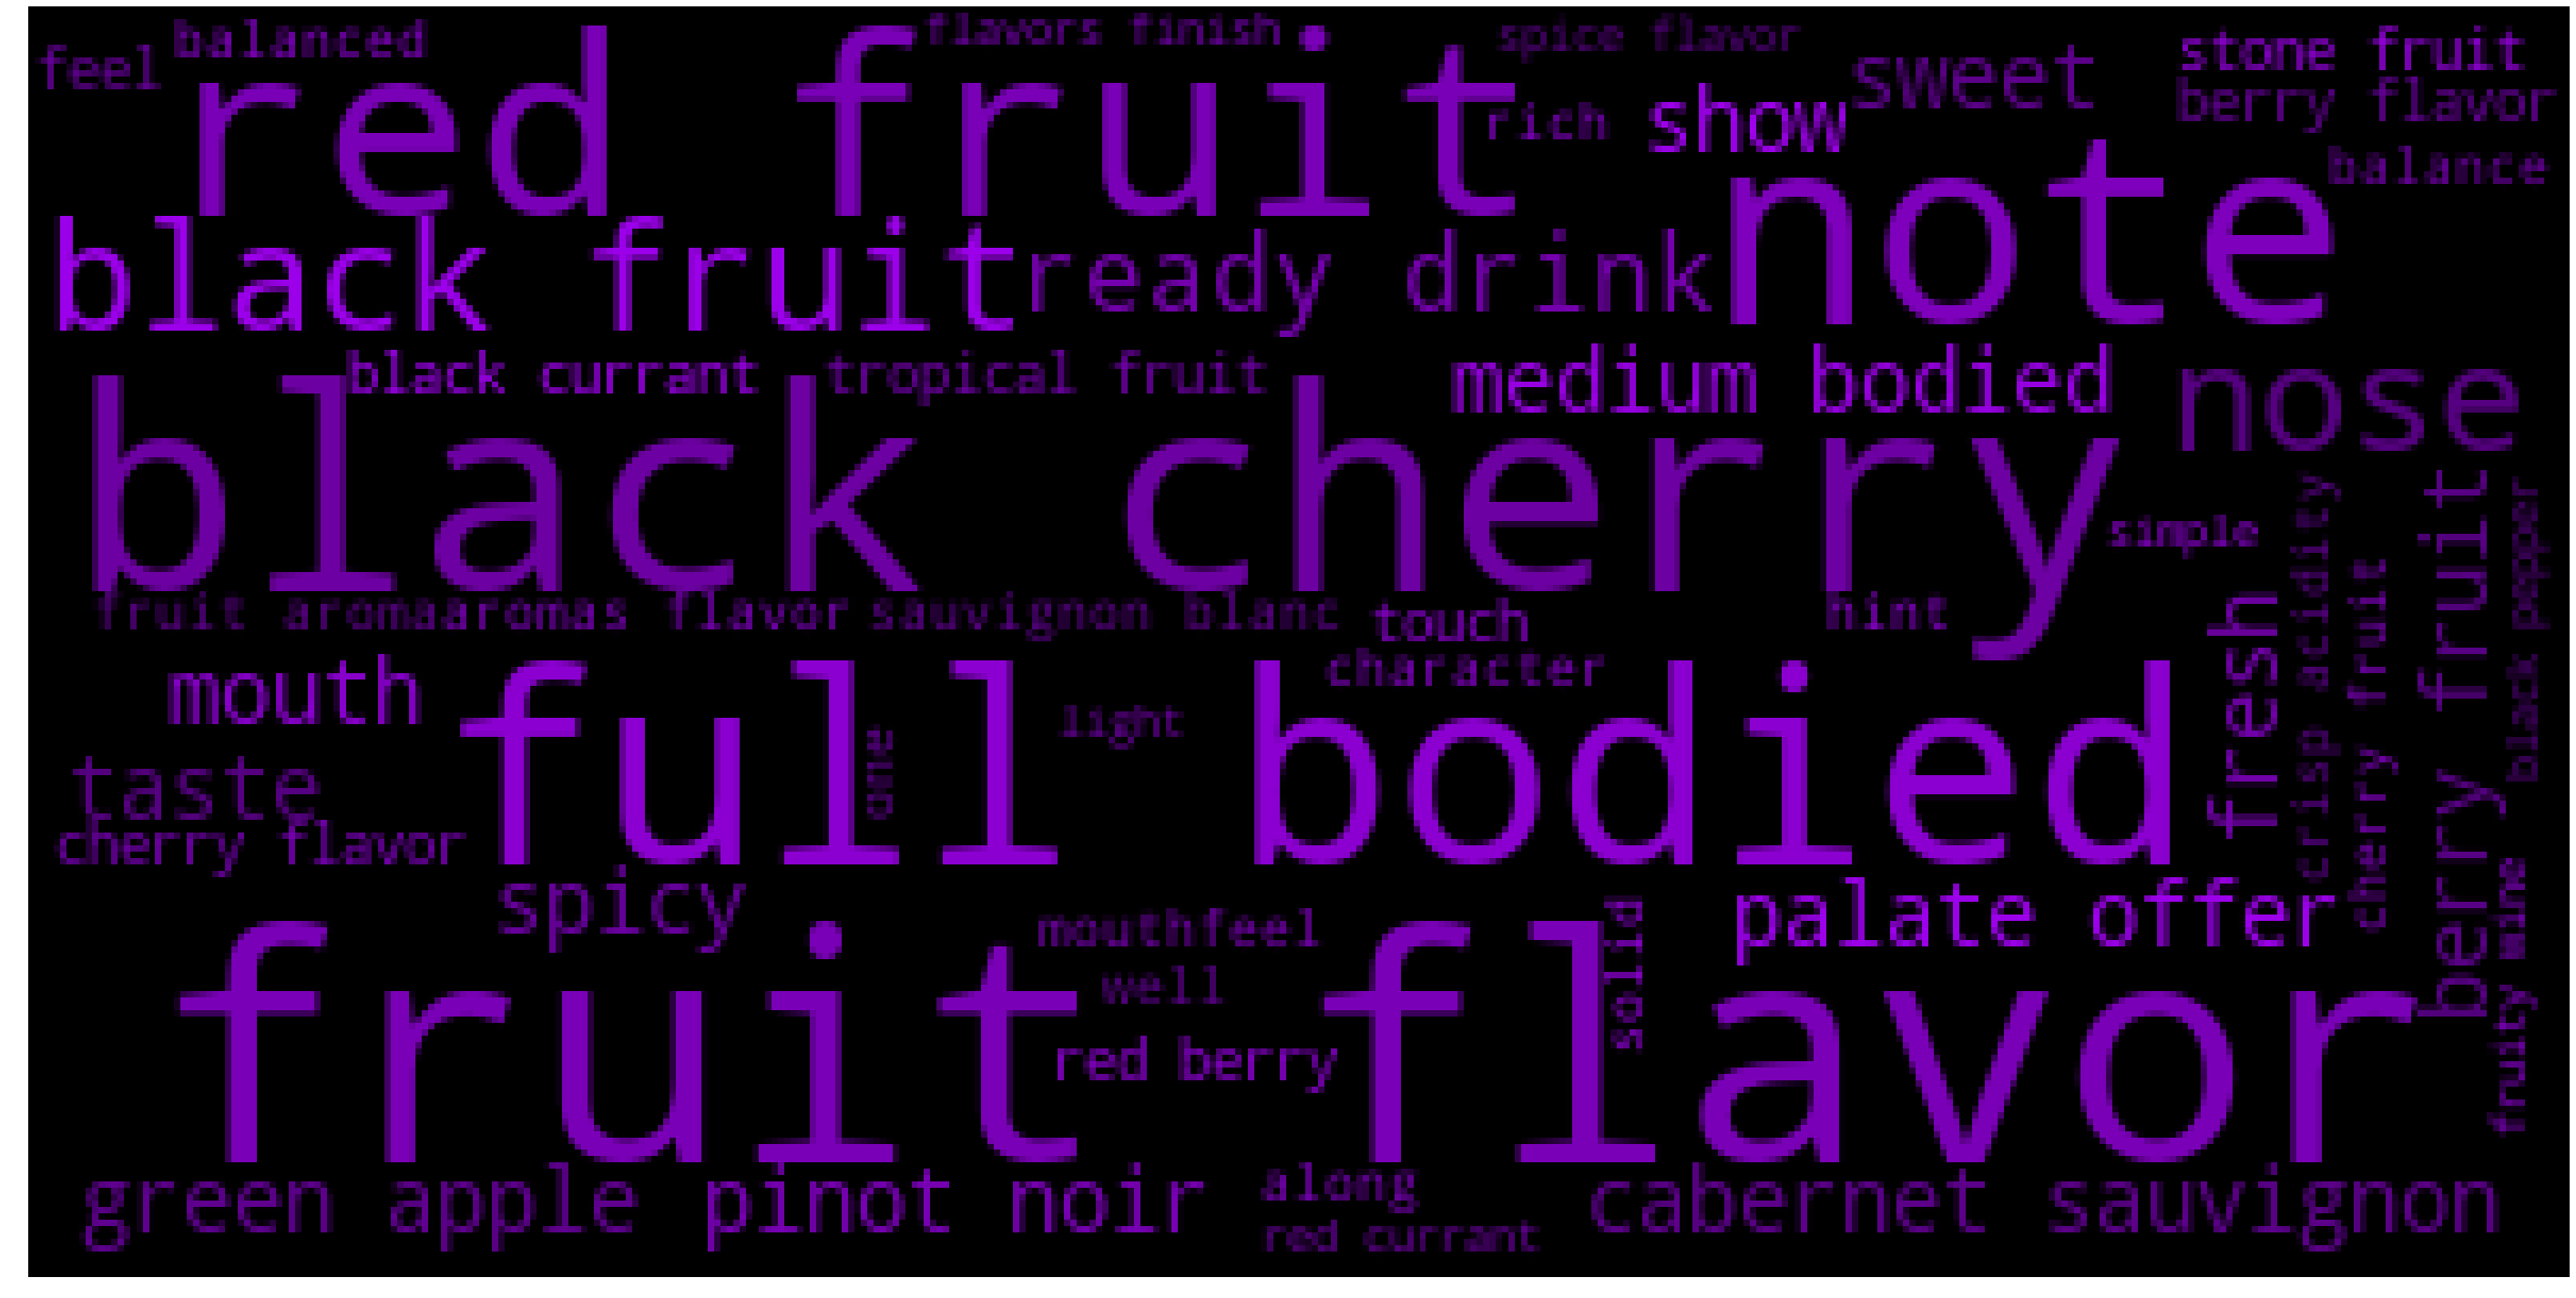

In [57]:
wc_sent(cleaned_data_descr_neu,'black','Common Words' )

##### Positive Sentiment

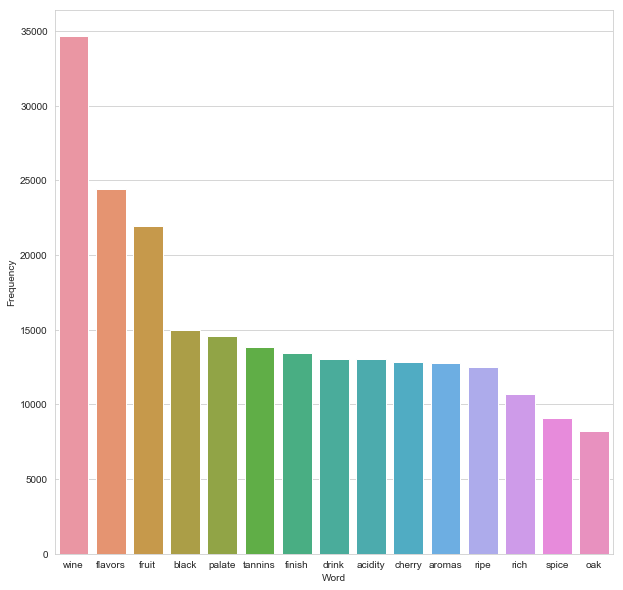

In [47]:
df_lower_pos = total_df[total_df['sentiment'] == 2]['description'].str.lower().str.cat(sep=' ')
df_pos = re.sub('[^A-Za-z]+', ' ', df_lower_pos)

#remove the stopwords from the text
stop_words = list(get_stop_words('en'))         
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)
word_tokens_pos = word_tokenize(df_pos)
filtered_sentence_pos = [w for w in word_tokens_pos if not w in stop_words]
filtered_sentence_pos = []
for w in word_tokens_pos:
    if w not in stop_words:
        filtered_sentence_pos.append(w)
# Remove characters which have length less than 2  
cleaned_data_descr_pos = [word for word in filtered_sentence_pos if len(word) > 2]   
# Calculate distribution
word_dist_pos = nltk.FreqDist(cleaned_data_descr_pos)
rslt_pos = pd.DataFrame(word_dist_pos.most_common(top_N), columns=['Word', 'Frequency'])
# plot top words
plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt_pos.head(15))

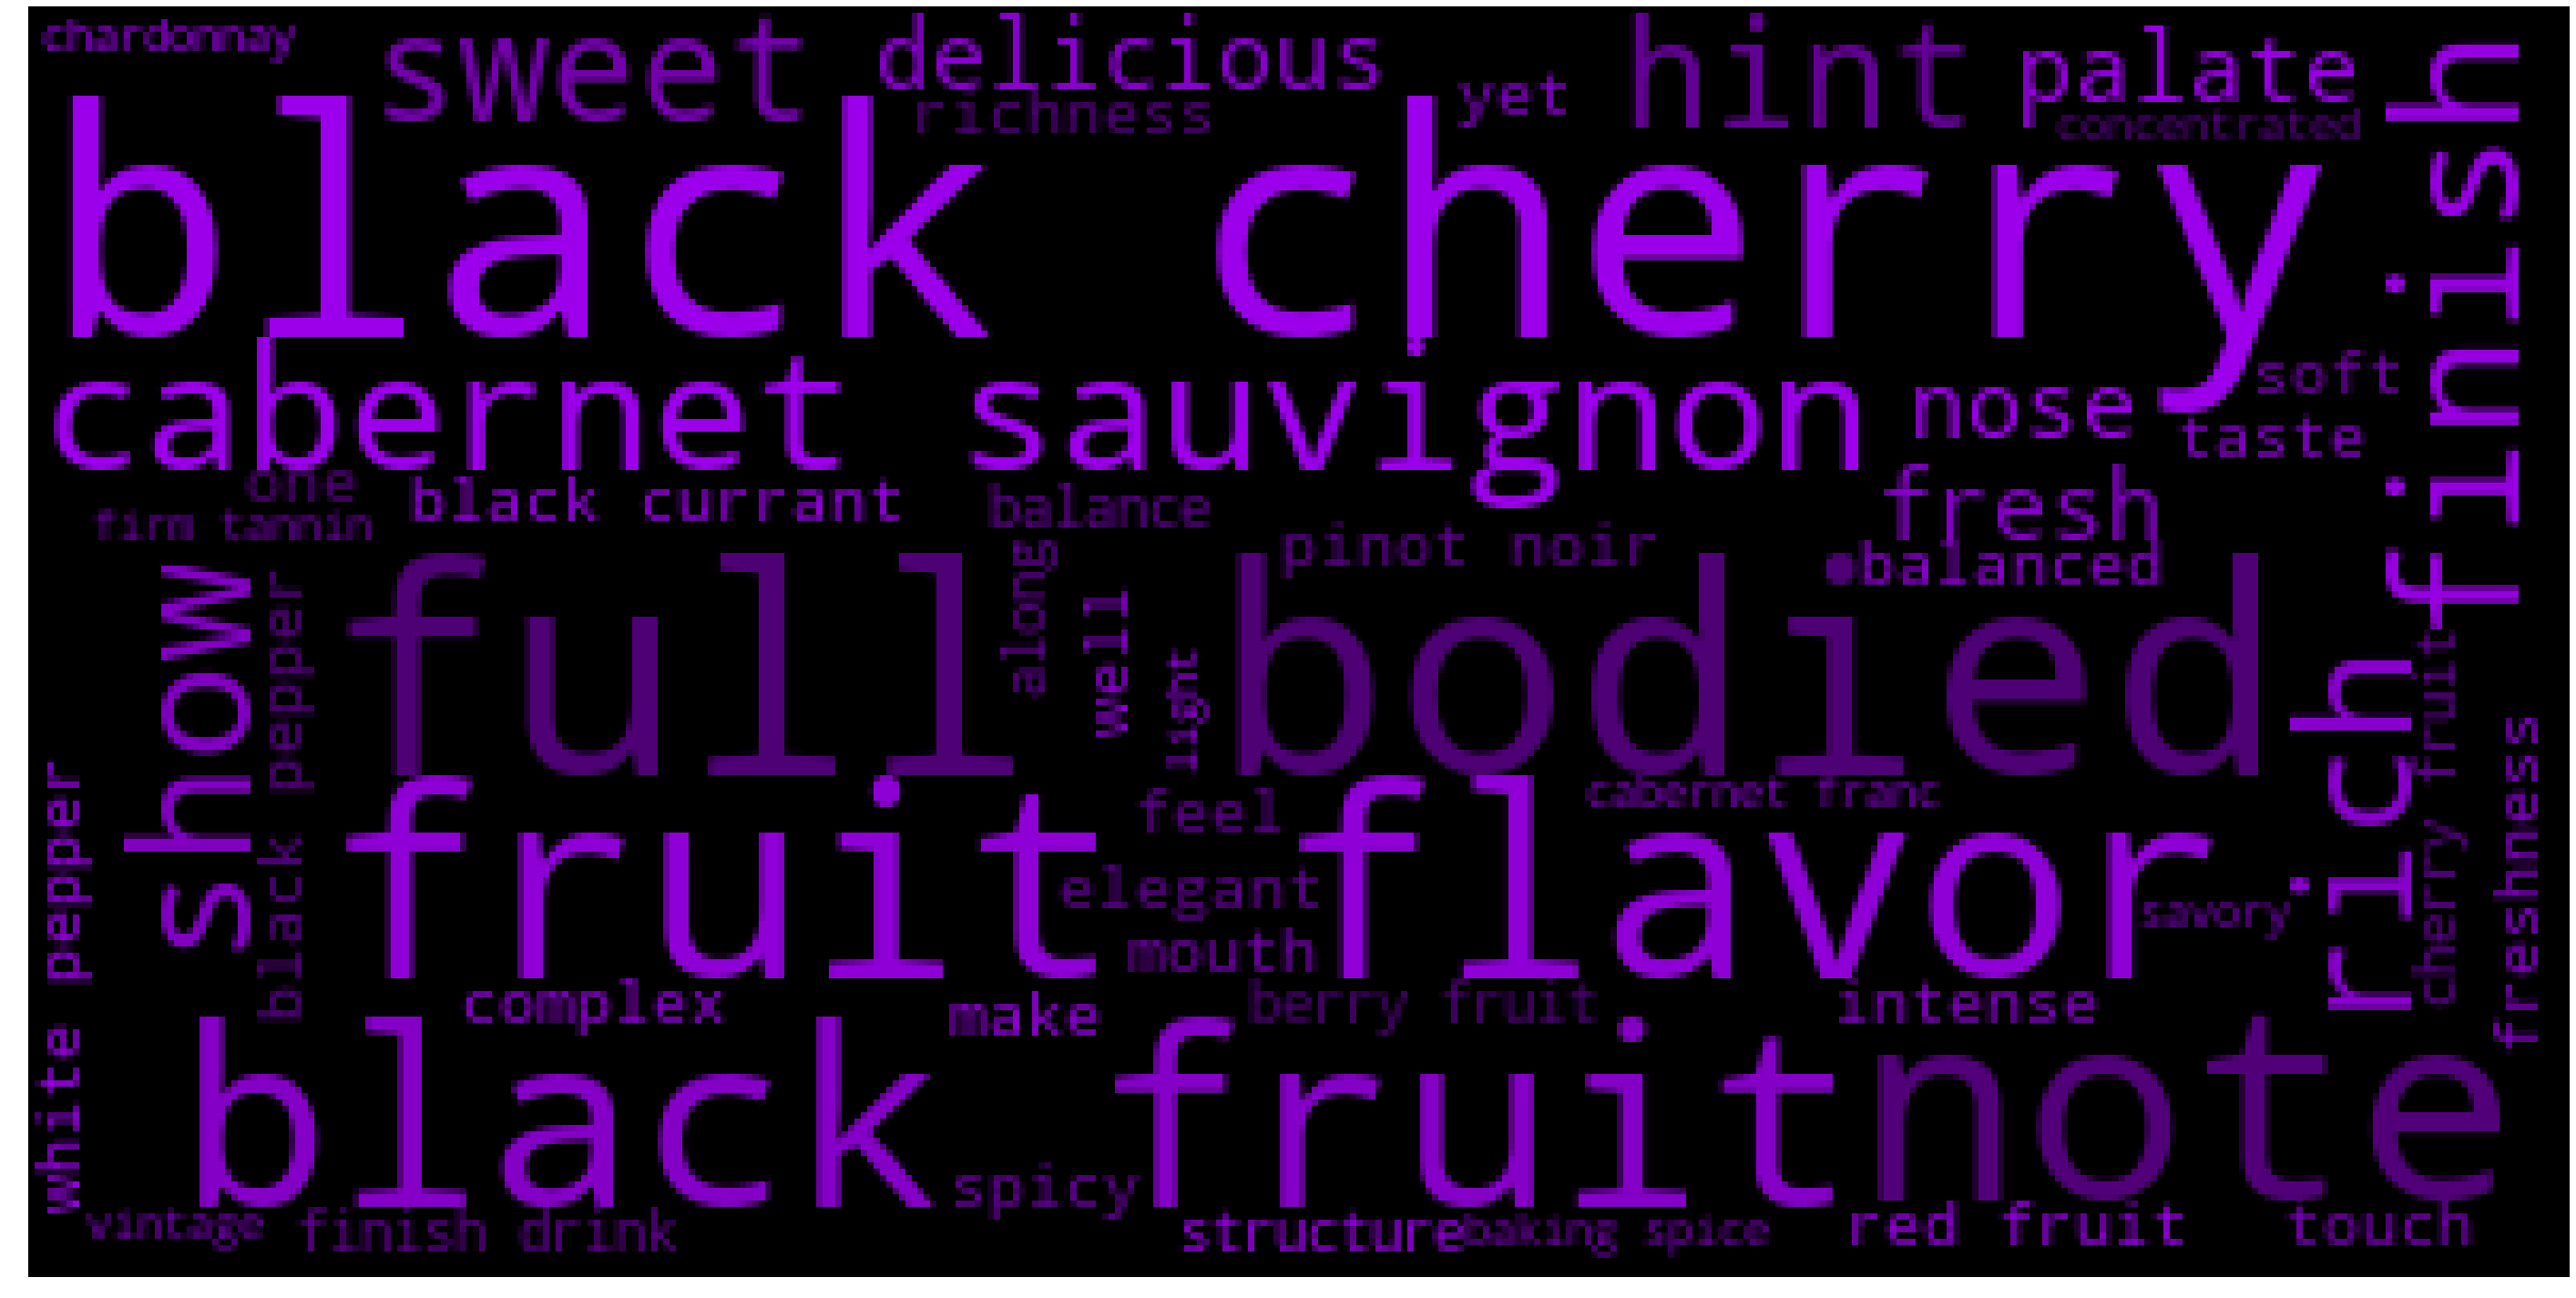

In [58]:
wc_sent(cleaned_data_descr_pos,'black','Common Words' )

##### Compare results

###### top 10 words are very similar among desriptions with different sentiments

In [50]:
rslt_pos.head(10)

,Word,Frequency
0,wine,34659
1,flavors,24437
2,fruit,21967
3,black,14959
4,palate,14570
5,tannins,13826
6,finish,13422
7,drink,13074
8,acidity,13030
9,cherry,12852


In [51]:
rslt_neu.head(10)

,Word,Frequency
0,wine,50078
1,flavors,48378
2,fruit,34014
3,aromas,27793
4,finish,25438
5,palate,24174
6,acidity,22178
7,cherry,19850
8,tannins,18495
9,drink,17159


In [52]:
rslt_neg.head(10)

,Word,Frequency
0,flavors,5979
1,wine,4223
2,fruit,2867
3,finish,2837
4,aromas,2828
5,palate,2448
6,sweet,2189
7,cherry,1776
8,nose,1449
9,dry,1414
